## Real graph, synthetic signals, baseline comparison

In [3]:
from opt import *
from time import perf_counter
import pickle

from joblib import Parallel, delayed
import os

from sklearn.covariance import graphical_lasso

import pandas as pd
from torch_geometric.utils import to_networkx, to_dense_adj

SEED = 1212
SAVE = False
PATH = './results/baseline_comp'
N_CPUS = os.cpu_count() // 2
np.random.seed(SEED)

os.environ['OMP_NUM_THREADS'] = str(N_CPUS)

In [4]:
def rewire_precmat(Theta, rewire=3, replace=False):
    p,p = Theta.shape
    theta = mat2lowtri(Theta)
    if not replace:
        for _ in range(rewire):
            ix = np.random.choice(len(theta),2,replace=replace)
            theta[[ix[0],ix[1]]] = theta[[ix[1],ix[0]]]
    else:
        ix = np.random.choice(len(theta), 2*rewire, replace=replace)
        for i in range(rewire):
            theta[[ix[i],ix[rewire+i]]] = theta[[ix[rewire+i],ix[i]]]
    Theta_rw = lowtri2mat(theta) + Theta*np.eye(p)
    return Theta_rw

In [5]:
# Load real dataset, Zachary's karate club

from torch_geometric.datasets import KarateClub
dataset = KarateClub()
data = dataset[0]

z = data.y.numpy()
Z = np.eye(len(np.unique(z)))[z].T
g,p = Z.shape
mask_Z = [[Z[a][:,None]*Z[b][None] for b in range(g)] for a in range(g)]
ccalZ = [[np.where(mask_Z[a][b]==1) for b in range(g)] for a in range(g)]
g,p = Z.shape
p_grp = [int(np.sum(Z[a])) for a in range(g)]

A = to_dense_adj(data.edge_index).numpy().astype(float).squeeze()
A = (A + A.T)/2
Sigma = create_gmrf_cov(A)
Theta = la.inv(Sigma)
Theta_od = Theta * (1-np.eye(p))

bias_true = compute_dp2(Theta_od,Z)
sqrt_bias_true = np.sqrt(compute_dp2(Theta_od,Z))
if np.mean(np.abs(mat2lowtri(Theta_od)))>0:
    sqrt_bias_true /= np.mean(np.abs(mat2lowtri(Theta_od)))
s = int(np.sum(A)/2)

In [8]:
# Create data for a given real network, then take subsets and plot
# Loop through several iterations of creating this data
# Each loop and each subset, compare multiple methods

SAMPLE_RANGE = np.logspace(2,5,5).astype(int)
num_params = len(SAMPLE_RANGE)
verbose = True
num_trials = 10
lo_ratio = .2
hi_ratio = .6

# Parameter choice before tuning (done via grid search)
mu1_range = np.sqrt(1/SAMPLE_RANGE)
mu2_range = np.array([50,50,50,50,50])

gl_mu1 = mu1_range
dp_mu1 = mu1_range
nw_mu1 = mu1_range
eusdp_mu1 = mu1_range
eusnw_mu1 = mu1_range

dp_mu2 = mu2_range
nw_mu2 = mu2_range
eusdp_mu2 = mu2_range
eusnw_mu2 = mu2_range

gl_params = [{
    'mu1':gl_mu1[i],
    'eta':1e-2,
    'mu2':0,
    'bias_type':'dp',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

dp_params = [{
    'mu1':dp_mu1[i],
    'eta':1e-2,
    'mu2':dp_mu2[i],
    'bias_type':'dp',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

nw_params = [{
    'mu1':nw_mu1[i],
    'eta':1e-2,
    'mu2':nw_mu2[i],
    'bias_type':'nodewise',
    'epsilon':.1,
    'iters':5000,
    'EARLY_STOP':True
} for i in range(num_params)]

eusdp_params = [{
    'alpha':eusdp_mu1[i],
    'beta':eusdp_mu2[i],
    'bias_type':'dp',
    'mu':1e4
} for i in range(num_params)]

eusnw_params = [{
    'alpha':eusnw_mu1[i],
    'beta':eusnw_mu2[i],
    'bias_type':'nodewise',
    'mu':1e4
} for i in range(num_params)]

rwlo = int(lo_ratio*kchoose2(p))
rwhi = int(hi_ratio*kchoose2(p))


### Parallelized version

In [9]:
def run_trial_karateclub(t:int, Theta, Z, SAMPLE_RANGE, params, verb:bool=False):
    gl_params = params['gl']
    dp_params = params['dp']
    nw_params = params['nw']
    eusdp_params = params['eusdp']
    eusnw_params = params['eusnw']
    rwlo = params['rwlo']
    rwhi = params['rwhi']

    # ------------------------------
    Thetas_all = dict(zip(['gl','dp','nwdp','stdp','stnwdp','rwlo','rwhi'],[None]*7))
    times_all = dict(zip(['gl','dp','nwdp','stdp','stnwdp','rwlo','rwhi'],[None]*7))

    num_params = len(SAMPLE_RANGE)
    p,p = Theta.shape
    Theta_od = Theta * (1-np.eye(p))

    Thetas_gl = []
    Thetas_dp = []
    Thetas_nw = []
    Thetas_eusdp = []
    Thetas_eusnw = []
    Thetas_rwlo = []
    Thetas_rwhi = []
    Xs_all = []
    
    time_gl = np.zeros(num_params)
    time_dp = np.zeros(num_params)
    time_nw = np.zeros(num_params)
    time_eusdp = np.zeros(num_params)
    time_eusnw = np.zeros(num_params)
    time_rwlo = np.zeros(num_params)
    time_rwhi = np.zeros(num_params)
    # ------------------------------


    # ------------------------------
    # Generate full set of samples
    n_max = np.max(SAMPLE_RANGE)
    X_max = gmrf_samples(Sigma,n_max).T
    Xs_all.append( X_max )
    # ------------------------------

    # ------------------------------
    for i,n in enumerate(SAMPLE_RANGE):
        print(f"No. samples: {n} | Trial {t+1} of {num_trials}")

        # ------------------------------
        # Subset of samples
        X = X_max[:n]
        Sigma_hat = X.T@X/n
        # ------------------------------

        # ------------------------------
        # GLASSO
        tic = perf_counter()
        Theta_gl = FairGLASSO_fista(Sigma_hat, Z=Z, **gl_params[i])
        Theta_gl_od = Theta_gl * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_gl_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_gl_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_gl_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_gl_od)))
            print( f'    ' + 
                   f'GLASSO:            '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_gl.append( Theta_gl )
        time_gl[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair GLASSO with DP
        tic = perf_counter()
        Theta_dp = FairGLASSO_fista(Sigma_hat, Z=Z, **dp_params[i])
        Theta_dp_od = Theta_dp * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_dp_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_dp_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_dp_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_dp_od)))
            print( f'    ' + 
                   f'DP:                '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_dp.append( Theta_dp )
        time_dp[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair GLASSO with Nw. DP
        tic = perf_counter()
        Theta_nw = FairGLASSO_fista(Sigma_hat, Z=Z, **nw_params[i])
        Theta_nw_od = Theta_nw * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_nw_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_nw_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_nw_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_nw_od)))
            print( f'    ' + 
                   f'Nw. DP:            '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_nw.append( Theta_nw )
        time_nw[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair SpecTemp with DP
        tic = perf_counter()
        Theta_eusdp = FGSR(Sigma_hat, Z=Z, **eusdp_params[i])
        Theta_eusdp_od = Theta_eusdp * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_eusdp_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_eusdp_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_eusdp_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_eusdp_od)))
            print( f'    ' + 
                   f'SpecTemp + DP:     '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_eusdp.append( Theta_eusdp )
        time_eusdp[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # Fair SpecTemp with Nw. DP
        tic = perf_counter()
        Theta_eusnw = FGSR(Sigma_hat, Z=Z, **eusnw_params[i])
        Theta_eusnw_od = Theta_eusnw * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_eusnw_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_eusnw_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_eusnw_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_eusnw_od)))
            print( f'    ' + 
                   f'SpecTemp + Nw. DP: '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_eusnw.append( Theta_eusnw )
        time_eusnw[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # GLASSO + rewiring few edges
        tic = perf_counter()
        Theta_rwlo = rewire_precmat( Theta_gl, rewire=rwlo, replace=True )
        Theta_rwlo_od = Theta_rwlo * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_rwlo_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_rwlo_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_rwlo_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_rwlo_od)))
            print( f'    ' + 
                   f'GLASSO + Rw. {rwlo}:   '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_rwlo.append( Theta_rwlo )
        time_rwlo[i] = np.abs(toc-tic)
        # ------------------------------
        
        
        # ------------------------------
        # GLASSO + rewiring few edges
        tic = perf_counter()
        Theta_rwhi = rewire_precmat( Theta_gl, rewire=rwhi, replace=True )
        Theta_rwhi_od = Theta_rwhi * (1-np.eye(p))
        toc = perf_counter()
        if verb:
            frob = compute_frob_err(Theta_rwhi_od, Theta_od)
            bias = np.sqrt(compute_dp2(Theta_rwhi_od,Z))
            if np.mean(np.abs(mat2lowtri(Theta_rwhi_od)))>1e-6:
                bias /= np.mean(np.abs(mat2lowtri(Theta_rwhi_od)))
            print( f'    ' + 
                   f'GLASSO + Rw. {rwhi}:   '
                   f'Err: {frob:.4f} | ' + 
                   f'Bias: {bias:.4f}')
        Thetas_rwhi.append( Theta_rwhi )
        time_rwhi[i] = np.abs(toc-tic)
        # ------------------------------

        if verb:
            print()
        
    Thetas_all['gl'] = Thetas_gl
    Thetas_all['dp'] = Thetas_dp
    Thetas_all['nwdp'] = Thetas_nw
    Thetas_all['stdp'] = Thetas_eusdp
    Thetas_all['stnwdp'] = Thetas_eusnw
    Thetas_all['rwlo'] = Thetas_rwlo
    Thetas_all['rwhi'] = Thetas_rwhi

    times_all['gl'] = time_gl
    times_all['dp'] = time_dp
    times_all['nwdp'] = time_nw
    times_all['stdp'] = time_eusdp
    times_all['stnwdp'] = time_eusnw
    times_all['rwlo'] = time_rwlo
    times_all['rwhi'] = time_rwhi

    return Thetas_all, Xs_all, times_all

In [10]:
bias_tr = bias_true * np.ones((num_trials,num_params))

frob_gl = np.zeros((num_trials,num_params))
f1sc_gl = np.zeros((num_trials,num_params))
time_gl = np.zeros((num_trials,num_params))
bias_gl = np.zeros((num_trials,num_params))

frob_dp = np.zeros((num_trials,num_params))
f1sc_dp = np.zeros((num_trials,num_params))
time_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_nw = np.zeros((num_trials,num_params))
f1sc_nw = np.zeros((num_trials,num_params))
time_nw = np.zeros((num_trials,num_params))
bias_nw = np.zeros((num_trials,num_params))

frob_eusdp = np.zeros((num_trials,num_params))
f1sc_eusdp = np.zeros((num_trials,num_params))
time_eusdp = np.zeros((num_trials,num_params))
bias_eusdp = np.zeros((num_trials,num_params))

frob_eusnw = np.zeros((num_trials,num_params))
f1sc_eusnw = np.zeros((num_trials,num_params))
time_eusnw = np.zeros((num_trials,num_params))
bias_eusnw = np.zeros((num_trials,num_params))

frob_rwlo = np.zeros((num_trials,num_params))
f1sc_rwlo = np.zeros((num_trials,num_params))
time_rwlo = np.zeros((num_trials,num_params))
bias_rwlo = np.zeros((num_trials,num_params))

frob_rwhi = np.zeros((num_trials,num_params))
f1sc_rwhi = np.zeros((num_trials,num_params))
time_rwhi = np.zeros((num_trials,num_params))
bias_rwhi = np.zeros((num_trials,num_params))

# # ------------------------------
params = {
    'gl':gl_params,
    'dp':dp_params,
    'nw':nw_params,
    'eusdp':eusdp_params,
    'eusnw':eusnw_params,
    'rwlo':rwlo,
    'rwhi':rwhi
}
# # ------------------------------

verb = False

# # ------------------------------
print(f'CPUs employed: {N_CPUS}')
t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_trial_karateclub)(t,Theta,Z,SAMPLE_RANGE,params,verb) for t in range(num_trials))
ellapsed_t = (perf_counter()-t_init)/60
print(f" --- Solved in {ellapsed_t:.3f} minutes --- ")
# # ------------------------------


CPUs employed: 12
No. samples: 100 | Trial 4 of 10
No. samples: 100 | Trial 2 of 10
No. samples: 100 | Trial 8 of 10
No. samples: 100 | Trial 6 of 10
No. samples: 100 | Trial 1 of 10
No. samples: 100 | Trial 3 of 10
No. samples: 100 | Trial 7 of 10
No. samples: 100 | Trial 9 of 10
No. samples: 100 | Trial 10 of 10
No. samples: 100 | Trial 5 of 10
No. samples: 562 | Trial 4 of 10
No. samples: 562 | Trial 2 of 10
No. samples: 562 | Trial 10 of 10
No. samples: 562 | Trial 8 of 10
No. samples: 562 | Trial 5 of 10
No. samples: 562 | Trial 6 of 10
No. samples: 562 | Trial 3 of 10
No. samples: 562 | Trial 1 of 10
No. samples: 562 | Trial 9 of 10
No. samples: 562 | Trial 7 of 10
No. samples: 3162 | Trial 4 of 10
No. samples: 3162 | Trial 2 of 10
No. samples: 3162 | Trial 10 of 10
No. samples: 3162 | Trial 3 of 10
No. samples: 3162 | Trial 8 of 10
No. samples: 3162 | Trial 5 of 10
No. samples: 3162 | Trial 1 of 10
No. samples: 3162 | Trial 6 of 10
No. samples: 3162 | Trial 9 of 10
No. samples: 

In [12]:
Thetas_all = [None]*num_trials
Xs_all = [None]*num_trials
times_all = [None]*num_trials

KEYS = ['gl', 'dp', 'nwdp', 'stdp', 'stnwdp', 'rwlo', 'rwhi']

for t in range(num_trials):
    Thetas_all[t], Xs_all[t], times_all[t] = results[t]

frob_all = {k:np.array([[compute_frob_err(Thetas_all[t][k][i]*(1-np.eye(p)),Theta_od,pre_norm=False) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
frob_normed_all = {k:np.array([[compute_frob_err(Thetas_all[t][k][i]*(1-np.eye(p)),Theta_od,pre_norm=True) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
bias_all = {k:np.array([[compute_dp2(Thetas_all[t][k][i]*(1-np.eye(p)),Z) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}
sqrt_bias_all = {k:np.array([[ np.sqrt(bias_all[k][t][i]) / np.mean(np.abs(mat2lowtri(Thetas_all[t][k][i]))) if np.mean(np.abs(mat2lowtri(Thetas_all[t][k][i])))>1e-6 else np.sqrt(bias_all[k][t][i]) for i in range(num_params)] for t in range(num_trials)]) for k in KEYS}

if SAVE:
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    file_name = PATH + '/' + f'baseline_comp_results.pkl'
    data = {
        'SAMPLE_RANGE':SAMPLE_RANGE,
        'params':params,
        'Theta':Theta,
        'Z':Z,
        'A':A,
        'Xs_all':Xs_all,
        'times_all':times_all,
        'Thetas_all':Thetas_all
    }
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
        print(f"Graphs saved in the following location: {file_name}")
    
    perfs_file_name =  PATH + '/' + f'baseline_comp_perf'
    np.savez(perfs_file_name, frob_all=frob_all, frob_normed_all=frob_normed_all, bias_all=bias_all, sqrt_bias_all=sqrt_bias_all)
    print(f"Performance saved in the following location: {perfs_file_name}")

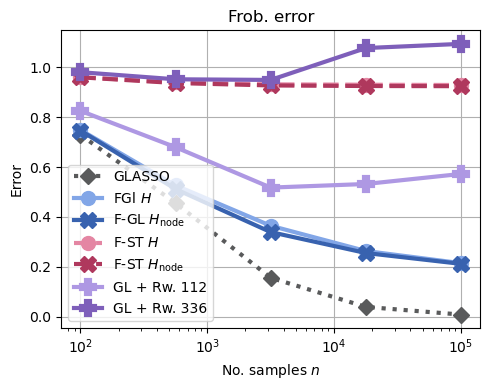

In [13]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'No. samples $n$'
x_range = SAMPLE_RANGE
# ------------------------

# ------------------------
y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = frob_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = frob_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = frob_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = frob_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = frob_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = frob_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = frob_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Frob. error')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

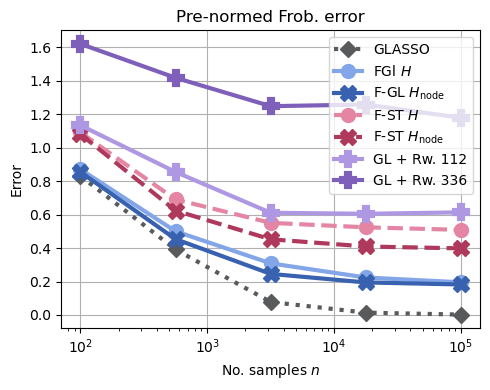

In [14]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'No. samples $n$'
x_range = SAMPLE_RANGE
# ------------------------

# ------------------------
y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = frob_normed_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = frob_normed_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = frob_normed_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = frob_normed_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = frob_normed_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = frob_normed_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = frob_normed_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Pre-normed Frob. error')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


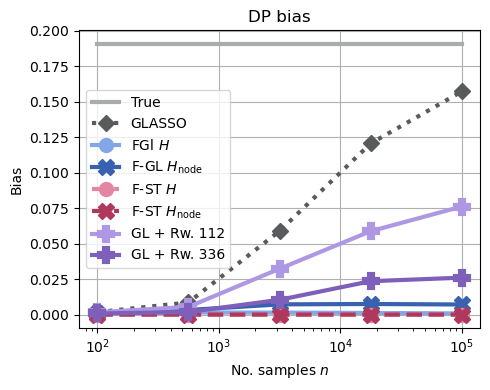

In [15]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'No. samples $n$'
x_range = SAMPLE_RANGE
# ------------------------

# ------------------------
y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[8]
label = 'True'
y_range = np.ones(num_params) * bias_true
mkr_args = {'marker':''} 
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = bias_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = bias_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = bias_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = bias_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = bias_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = bias_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = bias_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('DP bias')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


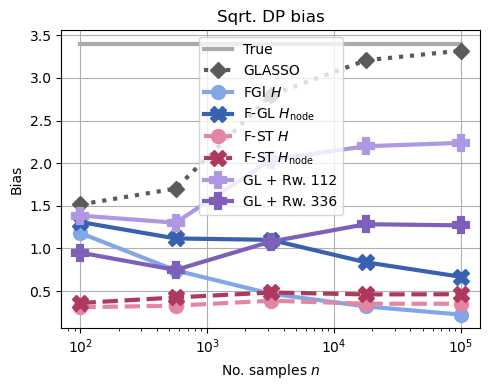

In [16]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':10, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':12, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':8, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':10, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':3 }
dash_args = { 'linestyle':'--', 'linewidth':3 }
dotted_args = { 'linestyle':':', 'linewidth':3 }
# ------------------------


# ------------------------
x_label = r'No. samples $n$'
x_range = SAMPLE_RANGE
# ------------------------

# ------------------------
y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------

# ------------------------
c = grays[8]
label = 'True'
y_range = np.ones(num_params) * sqrt_bias_true
mkr_args = {'marker':''} 
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = grays[18]
label = 'GLASSO'
y_range = sqrt_bias_all['gl'].mean(0)
mkr_args = diam_args
line_args = dotted_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------

# ------------------------
c = blues[6]
label = r'FGl $H$'
y_range = sqrt_bias_all['dp'].mean(0)
mkr_args = circ_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
y_range = sqrt_bias_all['nwdp'].mean(0)
mkr_args = cross_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
y_range = sqrt_bias_all['stdp'].mean(0)
mkr_args = circ_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
y_range = sqrt_bias_all['stnwdp'].mean(0)
mkr_args = cross_args
line_args = dash_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
y_range = sqrt_bias_all['rwlo'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
y_range = sqrt_bias_all['rwhi'].mean(0)
mkr_args = plus_args
line_args = solid_args

plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.semilogx(x_range,y_range, **plt_args )
# ------------------------
ax.set_title('Sqrt. DP bias')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()


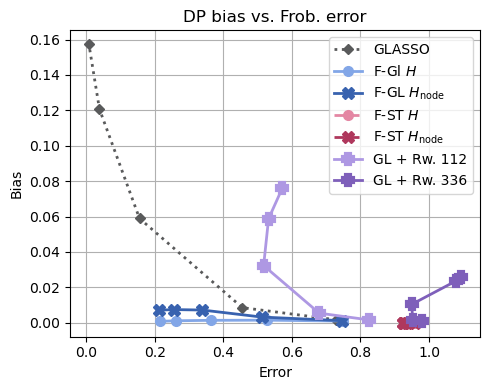

In [17]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = SAMPLE_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_all['gl'].mean(0)
y_range = bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_all['dp'].mean(0)
y_range = bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_all['nwdp'].mean(0)
y_range = bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_all['stdp'].mean(0)
y_range = bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_all['stnwdp'].mean(0)
y_range = bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwlo'].mean(0)
y_range = bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwhi'].mean(0)
y_range = bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('DP bias vs. Frob. error')

ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------


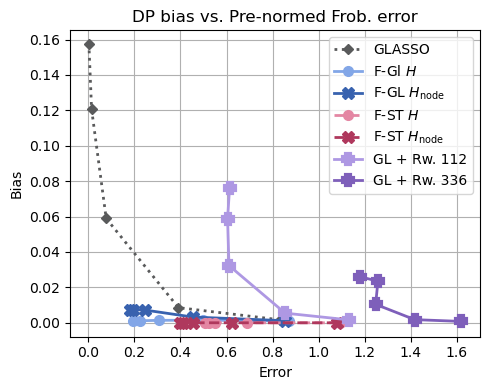

In [18]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = SAMPLE_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_normed_all['gl'].mean(0)
y_range = bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_normed_all['dp'].mean(0)
y_range = bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_normed_all['nwdp'].mean(0)
y_range = bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_normed_all['stdp'].mean(0)
y_range = bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_normed_all['stnwdp'].mean(0)
y_range = bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwlo'].mean(0)
y_range = bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwhi'].mean(0)
y_range = bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('DP bias vs. Pre-normed Frob. error')
ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------



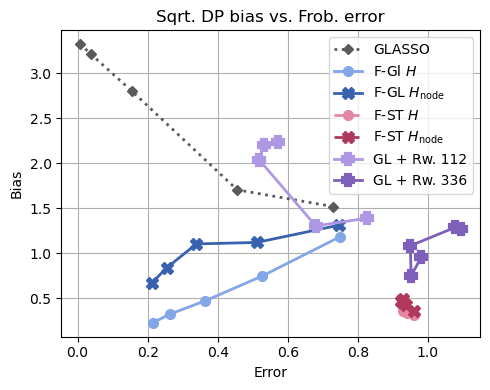

In [19]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = SAMPLE_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_all['gl'].mean(0)
y_range = sqrt_bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_all['dp'].mean(0)
y_range = sqrt_bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_all['nwdp'].mean(0)
y_range = sqrt_bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_all['stdp'].mean(0)
y_range = sqrt_bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_all['stnwdp'].mean(0)
y_range = sqrt_bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwlo'].mean(0)
y_range = sqrt_bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_all['rwhi'].mean(0)
y_range = sqrt_bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('Sqrt. DP bias vs. Frob. error')

ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------





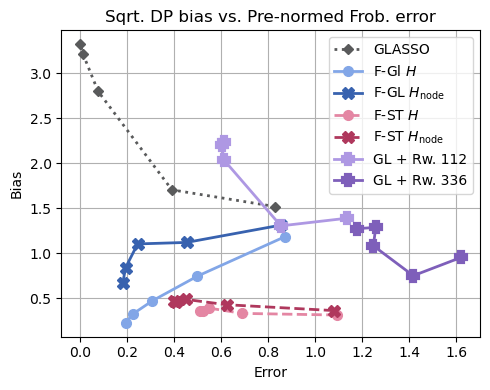

In [20]:
# ------------------------
circ_args  = { 'marker':'o', 'markersize':7, 'markeredgewidth':1 }
cross_args = { 'marker':'X', 'markersize':9, 'markeredgewidth':1 }
diam_args = { 'marker':'D', 'markersize':5, 'markeredgewidth':1 }
plus_args = { 'marker':'P', 'markersize':7, 'markeredgewidth':3 }

solid_args = { 'linestyle':'-', 'linewidth':2 }
dash_args = { 'linestyle':'--', 'linewidth':2 }
dotted_args = { 'linestyle':':', 'linewidth':2 }
# ------------------------


# ------------------------
x_label = 'Error'
y_label = 'Bias'
t_range = SAMPLE_RANGE
# ------------------------

# ------------------------
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()
# ------------------------


# ------------------------
c = grays[18]
label = 'GLASSO'
mkr_args = diam_args
line_args = dotted_args
x_range = frob_normed_all['gl'].mean(0)
y_range = sqrt_bias_all['gl'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[6]
label = r'F-Gl $H$'
mkr_args = circ_args
line_args = solid_args
x_range = frob_normed_all['dp'].mean(0)
y_range = sqrt_bias_all['dp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = blues[14]
label = r'F-GL $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = solid_args

x_range = frob_normed_all['nwdp'].mean(0)
y_range = sqrt_bias_all['nwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[6]
label = r'F-ST $H$'
mkr_args = circ_args
line_args = dash_args

x_range = frob_normed_all['stdp'].mean(0)
y_range = sqrt_bias_all['stdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = reds[14]
label = r'F-ST $H_{\mathrm{node}}$'
mkr_args = cross_args
line_args = dash_args

x_range = frob_normed_all['stnwdp'].mean(0)
y_range = sqrt_bias_all['stnwdp'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[6]
label = r'GL + Rw. '+f'{rwlo}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwlo'].mean(0)
y_range = sqrt_bias_all['rwlo'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
c = purples[14]
label = r'GL + Rw. '+f'{rwhi}'
mkr_args = plus_args
line_args = solid_args

x_range = frob_normed_all['rwhi'].mean(0)
y_range = sqrt_bias_all['rwhi'].mean(0)
plt_args = mkr_args | line_args | {'c':c, 'label':label}
ax.plot( x_range,y_range, **plt_args )
# ------------------------


# ------------------------
ax.set_title('Sqrt. DP bias vs. Pre-normed Frob. error')
ax.grid(True)
ax.legend()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
fig.tight_layout()
# ------------------------




In [6]:
# Loading data after experiment has been run

KEYS = ['gl', 'dp', 'nwdp', 'stdp', 'stnwdp', 'rwlo', 'rwhi']

fname = PATH + '/' + f'baseline_comp_results.pkl'
f = open(fname, 'rb')
results = pickle.load(f)
f.close()

SAMPLE_RANGE = results['SAMPLE_RANGE']
params = results['params']
Theta = results['Theta']
Z = results['Z']
A = results['A']
Xs_all = results['Xs_all']
times_all = results['times_all']
Thetas_all = results['Thetas_all']

perfs_file_name =  PATH + '/' + f'baseline_comp_perf' + '.npz'
res = np.load(perfs_file_name, allow_pickle=True)
frob_all = res['frob_all'].item()
frob_normed_all = res['frob_normed_all'].item()
bias_all = res['bias_all'].item()
sqrt_bias_all = res['sqrt_bias_all'].item()


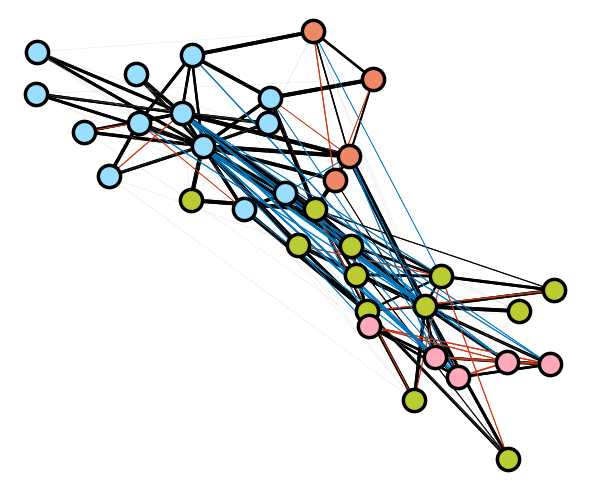

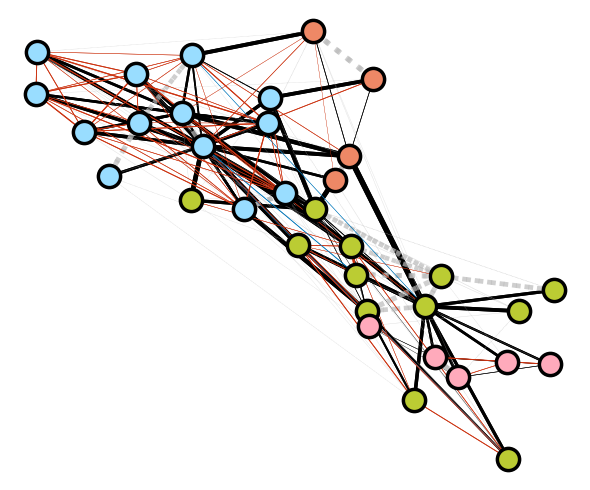

In [15]:
from plt_utils import *
import networkx as nx
from copy import deepcopy
Theta_nw = Thetas_all[0]['nwdp'][-2]
Theta_nw_od = Theta_nw * (1-np.eye(p))
edge_scale_nw = np.max(mat2lowtri(np.abs(Theta_nw_od)))

Theta_gl = Thetas_all[0]['gl'][-2]
Theta_gl_od = Theta_gl * (1-np.eye(p))
edge_scale_gl = np.max(mat2lowtri(np.abs(Theta_gl_od)))

Theta_dp = Thetas_all[0]['dp'][-2]
Theta_dp_od = Theta_dp * (1-np.eye(p))
edge_scale_dp = np.max(mat2lowtri(np.abs(Theta_dp_od)))

theta_dp = mat2lowtri(Theta_dp_od)
theta_dp[np.argsort(np.abs(theta_dp))[:-120]] = 0
theta_dp[np.abs(theta_dp)<1e-3] = 0
Theta_dp_sparse = lowtri2mat(theta_dp) + Theta_dp_od*(np.eye(p))
A_dp = (Theta_dp_sparse!=0).astype(int)

theta_nw = mat2lowtri(Theta_nw_od)
theta_nw[np.argsort(np.abs(theta_nw))[:-120]] = 0
theta_nw[np.abs(theta_nw)<1e-3] = 0
Theta_nw_sparse = lowtri2mat(theta_nw) + Theta_nw_od*(np.eye(p))
A_nw = (Theta_nw_sparse!=0).astype(int)

theta_gl = mat2lowtri(Theta_gl_od)
theta_gl[np.argsort(np.abs(theta_gl))[:-120]] = 0
theta_gl[np.abs(theta_gl)<1e-3] = 0
Theta_gl_sparse = lowtri2mat(theta_gl) + Theta_gl_od*(np.eye(p))
A_gl = (Theta_gl_sparse!=0).astype(int)

# madimshow(A_gl,'Reds')
# madimshow(A_dp,'Reds')
# madimshow(A_nw,'Reds')
# madimshow(np.abs(Theta_dp_sparse),'Reds')
# madimshow(np.abs(Theta_nw_sparse),'Reds')
# madimshow(np.abs(Theta_gl_sparse),'Reds')

# ------------------------------------

pos = np.array((list(nx.spring_layout(nx.Graph(np.abs(Theta_gl_od)),weight='weight').values())))
pos = np.array((list(nx.spring_layout(nx.Graph(Theta_gl_sparse),weight='weight').values())))

pos_grp = [pos[z==a] for a in range(g)]
clr_grp = [
    light_qual['cyan'], 
    light_qual['pear'], 
    light_qual['orange'], 
    light_qual['pink']]
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
node_grp_args = [] 
for a in range(g):
    node_grp_args.append(deepcopy(node_args))
    node_grp_args[a]['markerfacecolor'] = clr_grp[a]
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }

# ------------------------------------

edges_gl = np.array(np.where(A_gl==1)).T
edges_nw = np.array(np.where(A_nw==1)).T
edges_dp = np.array(np.where(A_dp==1)).T

edges_nw_shared = np.array(np.where(A_nw*A_gl==1)).T
edges_nw_add = np.array(np.where(A_nw-A_gl>0)).T
edges_nw_del = np.array(np.where(A_nw-A_gl<0)).T

edges_dp_shared = np.array(np.where(A_dp*A_gl==1)).T
edges_dp_add = np.array(np.where(A_dp-A_gl>0)).T
edges_dp_del = np.array(np.where(A_dp-A_gl<0)).T

# ------------------------------------

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for a in range(g):
    ax.plot(pos_grp[a][:,0],pos_grp[a][:,1],**node_grp_args[a])
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_nw_shared:
    edge_args['zorder'] = 1
    edge_args['linewidth'] = 4 * np.abs(Theta_nw_od[e[0],e[1]]) / edge_scale_nw
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_nw_add:
    edge_args['linestyle'] = '-'
    edge_args['zorder'] = 3
    if Theta_nw_od[e[0],e[1]]>=0:
        edge_args['c'] = vib_qual['blue']
    else:
        edge_args['c'] = vib_qual['red']
    edge_args['linewidth'] = 4 * np.abs(Theta_nw_od[e[0],e[1]]) / edge_scale_nw
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_nw_del:
    edge_args['c'] = bright_qual['gray']
    edge_args['linestyle'] = ':'
    edge_args['zorder'] = 2
    edge_args['linewidth'] = 4 * np.abs(Theta_gl_od[e[0],e[1]]) / edge_scale_gl
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args, alpha=.7 )

fig.tight_layout()

# ------------------------------------

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for a in range(g):
    ax.plot(pos_grp[a][:,0],pos_grp[a][:,1],**node_grp_args[a])
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_dp_shared:
    edge_args['zorder'] = 1
    edge_args['linewidth'] = 4 * np.abs(Theta_dp_od[e[0],e[1]]) / edge_scale_dp
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_dp_add:
    edge_args['linestyle'] = '-'
    edge_args['zorder'] = 3
    if Theta_dp_od[e[0],e[1]]>=0:
        edge_args['c'] = vib_qual['blue']
    else:
        edge_args['c'] = vib_qual['red']
    edge_args['linewidth'] = 4 * np.abs(Theta_dp_od[e[0],e[1]]) / edge_scale_dp
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_dp_del:
    edge_args['c'] = bright_qual['gray']
    edge_args['linestyle'] = ':'
    edge_args['zorder'] = 2
    edge_args['linewidth'] = 4 * np.abs(Theta_gl_od[e[0],e[1]]) / edge_scale_gl
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args, alpha=.7 )

fig.tight_layout()


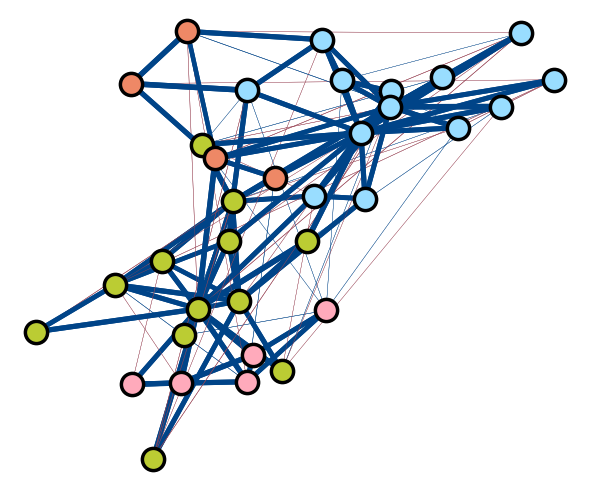

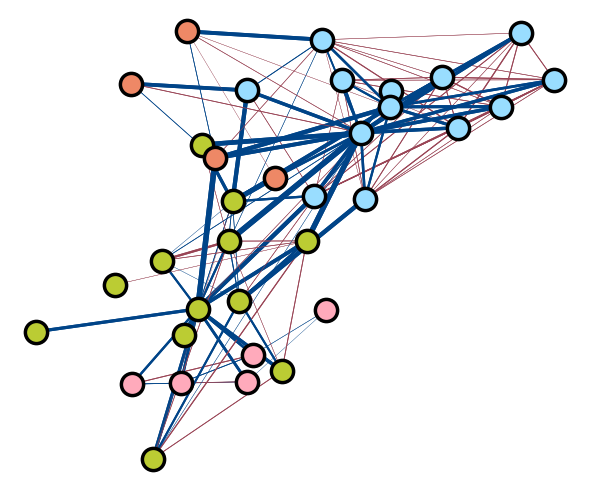

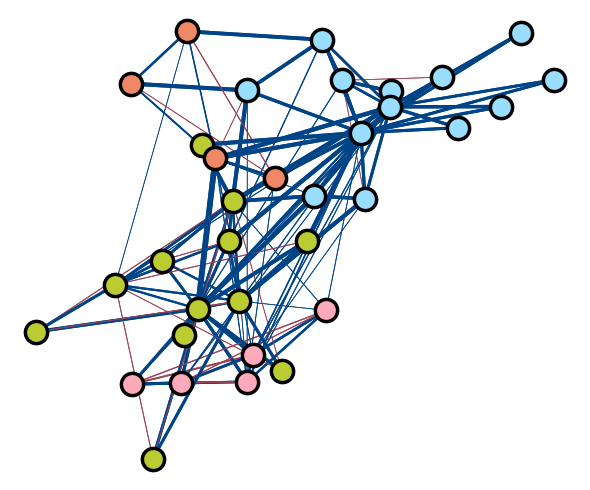

In [23]:
from plt_utils import *
import networkx as nx
from copy import deepcopy
Theta_nw = Thetas_all[0]['nwdp'][-2]
Theta_nw_od = Theta_nw * (1-np.eye(p))
edge_scale_nw = np.max(mat2lowtri(np.abs(Theta_nw_od)))

Theta_gl = Thetas_all[0]['gl'][-2]
Theta_gl_od = Theta_gl * (1-np.eye(p))
edge_scale_gl = np.max(mat2lowtri(np.abs(Theta_gl_od)))

Theta_dp = Thetas_all[0]['dp'][-2]
Theta_dp_od = Theta_dp * (1-np.eye(p))
edge_scale_dp = np.max(mat2lowtri(np.abs(Theta_dp_od)))

theta_dp = mat2lowtri(Theta_dp_od)
theta_dp[np.argsort(np.abs(theta_dp))[:-120]] = 0
theta_dp[np.abs(theta_dp)<1e-3] = 0
Theta_dp_sparse = lowtri2mat(theta_dp) + Theta_dp_od*(np.eye(p))
A_dp = (Theta_dp_sparse!=0).astype(int)

theta_nw = mat2lowtri(Theta_nw_od)
theta_nw[np.argsort(np.abs(theta_nw))[:-120]] = 0
theta_nw[np.abs(theta_nw)<1e-3] = 0
Theta_nw_sparse = lowtri2mat(theta_nw) + Theta_nw_od*(np.eye(p))
A_nw = (Theta_nw_sparse!=0).astype(int)

theta_gl = mat2lowtri(Theta_gl_od)
theta_gl[np.argsort(np.abs(theta_gl))[:-120]] = 0
theta_gl[np.abs(theta_gl)<1e-3] = 0
Theta_gl_sparse = lowtri2mat(theta_gl) + Theta_gl_od*(np.eye(p))
A_gl = (Theta_gl_sparse!=0).astype(int)

# ------------------------------------
# Plotting each network separately with color coded edges for sign

pos = np.array((list(nx.spring_layout(nx.Graph(np.abs(Theta_gl_od)),weight='weight').values())))
pos = np.array((list(nx.spring_layout(nx.Graph(Theta_gl_sparse),weight='weight').values())))

# ------------------------------------
clr_grp = [
    light_qual['cyan'], 
    light_qual['pear'], 
    light_qual['orange'], 
    light_qual['pink']]
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }

tru_edge_pos = medcont_qual['dark_blue']
tru_edge_neg = medcont_qual['dark_red']
del_edge_pos = medcont_qual['light_blue']
del_edge_neg = medcont_qual['light_red']
add_edge_pos = light_qual['cyan']
add_edge_neg = light_qual['pink']

# ------------------------------------


# ------------------------------------
edges_gl = np.array(np.where(A_gl==1)).T
edges_nw = np.array(np.where(A_nw==1)).T
edges_dp = np.array(np.where(A_dp==1)).T

edges_nw_shared = np.array(np.where(A_nw*A_gl==1)).T
edges_nw_add = np.array(np.where(A_nw-A_gl>0)).T
edges_nw_del = np.array(np.where(A_nw-A_gl<0)).T

edges_dp_shared = np.array(np.where(A_dp*A_gl==1)).T
edges_dp_add = np.array(np.where(A_dp-A_gl>0)).T
edges_dp_del = np.array(np.where(A_dp-A_gl<0)).T
# ------------------------------------


# ------------------------------------
# GLASSO plot

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for i in range(p):
    node_args['markerfacecolor'] = clr_grp[z[i]]
    ax.plot(pos[i,0],pos[i,1],**node_args)
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_gl:
    # Edge color
    edge_args['c'] = tru_edge_pos if Theta_gl_od[e[0],e[1]]>0 else tru_edge_neg
    
    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_gl_od[e[0],e[1]]) / edge_scale_gl

    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )

fig.tight_layout()
# ------------------------------------


# ------------------------------------
# Fair GLASSO + H plot

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for i in range(p):
    node_args['markerfacecolor'] = clr_grp[z[i]]
    ax.plot(pos[i,0],pos[i,1],**node_args)
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_dp:
    # Edge color
    edge_args['c'] = tru_edge_pos if Theta_dp_od[e[0],e[1]]>0 else tru_edge_neg
    
    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_dp_od[e[0],e[1]]) / edge_scale_dp

    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )

fig.tight_layout()
# ------------------------------------


# ------------------------------------
# Fair GLASSO + H_node plot

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for i in range(p):
    node_args['markerfacecolor'] = clr_grp[z[i]]
    ax.plot(pos[i,0],pos[i,1],**node_args)
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }
for e in edges_nw:
    # Edge color
    edge_args['c'] = tru_edge_pos if Theta_nw_od[e[0],e[1]]>0 else tru_edge_neg
    
    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_nw_od[e[0],e[1]]) / edge_scale_nw

    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )

fig.tight_layout()
# ------------------------------------

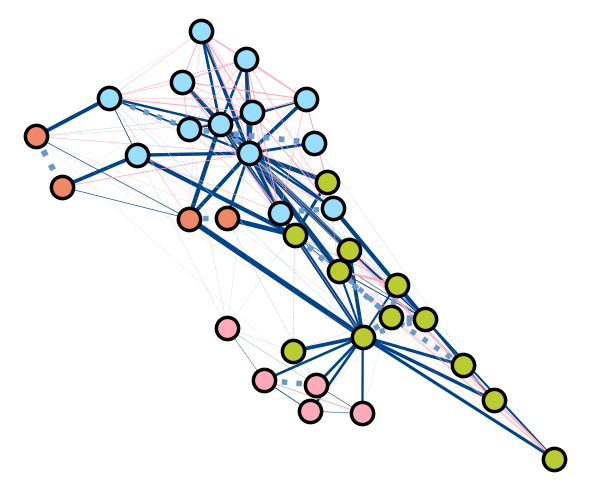

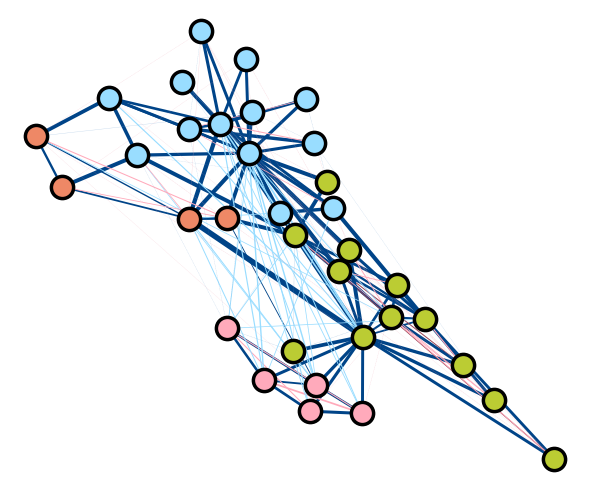

In [22]:
from plt_utils import *
import networkx as nx
from copy import deepcopy
Theta_nw = Thetas_all[0]['nwdp'][-2]
Theta_nw_od = Theta_nw * (1-np.eye(p))
edge_scale_nw = np.max(mat2lowtri(np.abs(Theta_nw_od)))

Theta_gl = Thetas_all[0]['gl'][-2]
Theta_gl_od = Theta_gl * (1-np.eye(p))
edge_scale_gl = np.max(mat2lowtri(np.abs(Theta_gl_od)))

Theta_dp = Thetas_all[0]['dp'][-2]
Theta_dp_od = Theta_dp * (1-np.eye(p))
edge_scale_dp = np.max(mat2lowtri(np.abs(Theta_dp_od)))

theta_dp = mat2lowtri(Theta_dp_od)
theta_dp[np.argsort(np.abs(theta_dp))[:-120]] = 0
theta_dp[np.abs(theta_dp)<1e-3] = 0
Theta_dp_sparse = lowtri2mat(theta_dp) + Theta_dp_od*(np.eye(p))
A_dp = (Theta_dp_sparse!=0).astype(int)

theta_nw = mat2lowtri(Theta_nw_od)
theta_nw[np.argsort(np.abs(theta_nw))[:-120]] = 0
theta_nw[np.abs(theta_nw)<1e-3] = 0
Theta_nw_sparse = lowtri2mat(theta_nw) + Theta_nw_od*(np.eye(p))
A_nw = (Theta_nw_sparse!=0).astype(int)

theta_gl = mat2lowtri(Theta_gl_od)
theta_gl[np.argsort(np.abs(theta_gl))[:-120]] = 0
theta_gl[np.abs(theta_gl)<1e-3] = 0
Theta_gl_sparse = lowtri2mat(theta_gl) + Theta_gl_od*(np.eye(p))
A_gl = (Theta_gl_sparse!=0).astype(int)

# ------------------------------------
# Plotting each network separately with color coded edges for sign

pos = np.array((list(nx.spring_layout(nx.Graph(np.abs(Theta_gl_od)),weight='weight').values())))
pos = np.array((list(nx.spring_layout(nx.Graph(Theta_gl_sparse),weight='weight').values())))

# ------------------------------------
clr_grp = [
    light_qual['cyan'], 
    light_qual['pear'], 
    light_qual['orange'], 
    light_qual['pink']]
alpha = 1
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3 }

tru_edge_pos = medcont_qual['dark_blue']
tru_edge_neg = medcont_qual['dark_red']
del_edge_pos = medcont_qual['light_blue']
del_edge_neg = medcont_qual['light_red']
add_edge_pos = light_qual['cyan']
add_edge_neg = light_qual['pink']

# ------------------------------------


# ------------------------------------
edges_gl = np.array(np.where(A_gl*np.tril(np.ones((p,p)),-1)==1)).T
edges_nw = np.array(np.where(A_nw*np.tril(np.ones((p,p)),-1)==1)).T
edges_dp = np.array(np.where(A_dp*np.tril(np.ones((p,p)),-1)==1)).T

edges_nw_shared = np.array(np.where(A_nw*A_gl*np.tril(np.ones((p,p)),-1)==1)).T
edges_nw_add = np.array(np.where((A_nw-A_gl)*np.tril(np.ones((p,p)),-1)>0)).T
edges_nw_del = np.array(np.where((A_nw-A_gl)*np.tril(np.ones((p,p)),-1)<0)).T

edges_dp_shared = np.array(np.where(A_dp*A_gl*np.tril(np.ones((p,p)),-1)==1)).T
edges_dp_add = np.array(np.where((A_dp-A_gl)*np.tril(np.ones((p,p)),-1)>0)).T
edges_dp_del = np.array(np.where((A_dp-A_gl)*np.tril(np.ones((p,p)),-1)<0)).T
# ------------------------------------


# ------------------------------------
# GLASSO vs. Fair GLASSO + H plot

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for i in range(p):
    node_args['markerfacecolor'] = clr_grp[z[i]]
    ax.plot(pos[i,0],pos[i,1],**node_args)
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_dp_shared:
    # Edge color
    edge_args['c'] = tru_edge_pos if Theta_dp_od[e[0],e[1]]>0 else tru_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_dp_od[e[0],e[1]]) / edge_scale_dp
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_dp_add:
    # Edge color
    edge_args['c'] = add_edge_pos if Theta_dp_od[e[0],e[1]]>0 else add_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_dp_od[e[0],e[1]]) / edge_scale_dp
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_dp_del:
    edge_args['linestyle'] = ':'

    # Edge color
    edge_args['c'] = del_edge_pos if Theta_gl_od[e[0],e[1]]>0 else del_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_gl_od[e[0],e[1]]) / edge_scale_dp
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )

fig.tight_layout()
# ------------------------------------



# ------------------------------------
# GLASSO vs. Fair GLASSO + H_node plot

fig = plt.figure(figsize=(6,5))
ax = fig.subplots()

# Nodes
node_args = { 'marker':'o', 'linestyle':'', 'markeredgewidth':2.5, 'markersize':16, 'markerfacecolor':None, 'markeredgecolor':'k', 'zorder':4 }
for i in range(p):
    node_args['markerfacecolor'] = clr_grp[z[i]]
    ax.plot(pos[i,0],pos[i,1],**node_args)
ax.axis('off')

# Edges
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_nw_shared:
    # Edge color
    edge_args['c'] = tru_edge_pos if Theta_nw_od[e[0],e[1]]>0 else tru_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_nw_od[e[0],e[1]]) / edge_scale_nw
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_nw_add:
    # Edge color
    edge_args['c'] = add_edge_pos if Theta_nw_od[e[0],e[1]]>0 else add_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_nw_od[e[0],e[1]]) / edge_scale_nw
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )
edge_args = { 'marker':'', 'linestyle':'-', 'linewidth':2.5, 'c':'k', 'zorder':3, 'alpha':alpha }
for e in edges_nw_del:
    edge_args['linestyle'] = ':'

    # Edge color
    edge_args['c'] = del_edge_pos if Theta_gl_od[e[0],e[1]]>0 else del_edge_neg

    # Edge width
    edge_args['linewidth'] = 4 * np.abs(Theta_gl_od[e[0],e[1]]) / edge_scale_nw
    
    ax.plot( [pos[e[0],0], pos[e[1],0]], [pos[e[0],1], pos[e[1],1]], **edge_args )

fig.tight_layout()
# ------------------------------------